In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#xgb and sklearn imports
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Loading in the Data

In [3]:
#creating a single table with all features of interest
path = '/content/drive/My Drive/Blueprint_Datathon/Data/Disparities/'

acs_county_data = pd.read_csv(path + 'acs_subset_county_level_economic_data.csv')
county_level_data = pd.read_csv(path + 'county_level_data.csv').drop('Unnamed: 0', axis=1)

merged = county_level_data.merge(acs_county_data, left_on=['CountyName', 'State'], right_on=["COUNTY", "REGION"], how='inner')
merged.drop_duplicates(['CountyName', 'StateName'], inplace=True)
merged.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PLACE_OF_BIRTH_Native,PLACE_OF_BIRTH_Foreign_Born,PLACE_OF_BIRTH_Entered_2010_or_Later,PLACE_OF_BIRTH_Entered _2000_to_2009,PLACE_OF_BIRTH_Entered_Before_2000,PLACE_OF_BIRTH_Naturalized_US_ Citizen,PLACE_OF_BIRTH_Not_US_ Citizen,LANGUAGE_Population_5_Years_and_Over,LANGUAGE_English_Only,LANGUAGE_Other_Than_ English,LANGUAGE_Limited_English,EMPLOYMENT_STATUS_Population_16_Years_And_Over,EMPLOYMENT_STATUS_In_Labor_Force,EMPLOYMENT_STATUS_Civilian labor force,EMPLOYMENT_STATUS_Employed,EMPLOYMENT_STATUS_Unemployed,EMPLOYMENT_STATUS_Percent_Civilian_Labor_Force,EMPLOYMENT_STATUS_Percent_Armed forces,EMPLOYMENT_STATUS_Not_in_Labor_Force,INCOME_12_MONTHS_Population,INCOME_12_MONTHS_With_Earnings,INCOME_12_MONTHS_Mean_Dollars_Earned,INCOME_12_MONTHS_WITH_Social_Security,INCOME_12_MONTHS_SS_Mean_Dollars,INCOME_12_MONTHS_With_Suppl_Security_Income,INCOME_12_MONTHS_Mean_Suppl_Sec_Dollars,INCOME_12_MONTHS_With_Cash_Public_Assistance,INCOME_12_MONTHS_Mean_Cash_Public_Assistance_Dollars,INCOME_12_MONTHS_With_Retirement_Income,INCOME_12_MONTHS_Mean_Retirement_Income_Dollars,INCOME_12_MONTHS_With_Food_Stamps,POVERTY_STATUS_Population,POVERTY_STATUS_Below_100_Percent_Level,POVERTY_STATUS_100_to_149_Percent_Level,POVERTY_STATUS_Above_150_Percent_Level,HOUSING_Total_Occupied_Units,HOUSING_HH_Size_Owner,HOUSING_HH_Size_Renter,HOUSING_No_Phone,HOUSING_OVER_1_Occupant_Per_Room
0,36047,36,47,Kings,NY,New York,40.640578,-73.954654,40.650523,-73.954811,Northeast,Middle Atlantic,1,2582830,1254966,1393805,0.473792,356714,35369.2,2504700,34.1,386673,309657,635.0,9.7,195.8,19.5,13.840802,23.05,35442,9307,6,12,318,4.541512,90415,86783,81356,78035,79604,...,1664420.0,918410.0,0.203,0.223,0.574,0.620,0.380,2395734.0,0.557,0.443,0.213,2050989.0,0.635,0.634,0.603,0.031,0.049,0.000,0.365,969317.0,0.783,102086.0,0.253,16939.0,0.090,9350.0,0.046,3248.000,0.119,25240.0,0.223,2557510.0,0.190,0.096,0.714,969317.0,2.97,2.47,0.018,0.095
2,36081,36,81,Queens,NY,New York,40.683532,-73.814712,40.721294,-73.833451,Northeast,Middle Atlantic,1,2278906,1143190,1215392,0.484694,354809,20553.6,2230722,37.2,374573,308099,411.0,10.2,180.0,22.2,12.427777,24.13,16874,7009,5,6,129,3.463349,67891,64573,63406,60360,62931,...,1193111.0,1085795.0,0.214,0.239,0.546,0.583,0.417,2137881.0,0.436,0.564,0.294,1869987.0,0.643,0.643,0.610,0.033,0.052,0.000,0.357,788110.0,0.809,93677.0,0.288,18027.0,0.056,9592.0,0.028,3196.000,0.152,26479.0,0.130,2250553.0,0.115,0.090,0.795,788110.0,3.02,2.72,0.012,0.100
4,6037,6,37,Los Angeles,CA,California,34.369957,-118.212742,34.065193,-118.244222,West,Pacific,1,10105518,5009834,5153673,0.492924,1343960,2419.6,9818605,34.8,1530126,1276832,2515.0,8.1,150.8,33.9,10.847678,34.94,157325,36517,22,76,2126,3.201541,330265,315528,323676,310014,347102,...,6665507.0,3440011.0,0.148,0.209,0.643,0.527,0.473,9503011.0,0.431,0.569,0.230,8162030.0,0.650,0.649,0.613,0.036,0.056,0.000,0.350,3313908.0,0.828,99981.0,0.252,17850.0,0.069,9890.0,0.032,4489.000,0.116,33920.0,0.083,9953165.0,0.141,0.100,0.759,3313908.0,3.20,2.83,0.013,0.112
6,17031,17,31,Cook,IL,Illinois,41.842959,-87.821180,41.865937,-87.757714,Midwest,East North Central,1,5180493,2530605,2680658,0.485603,743329,5495.1,5194675,35.3,845162,686929,1166.0,9.0,175.1,38.7,13.776183,41.02,111488,26136,24,46,1606,3.556127,174153,1

# Finding Maximum Proportion of Infected Individuals for each County

In [4]:
#Proportion of infected individuals per county at a particular time point
cases = county_level_data.iloc[:,87:355]
division_cases = pd.concat([merged[['CountyName', 'StateName']], cases.div(merged['PopulationEstimate2018'], axis=0)], axis=1)
division_cases = division_cases.pivot_table(columns=['CountyName', 'StateName'])
division_cases.tail()

CountyName            Adams   Alameda Allegheny  ...      Will Williamson Worcester
StateName                CO        CA        PA  ...        IL         TX        MA
#Cases_10-11-2020  0.023307  0.005664  0.010760  ...  0.014200   0.013471  0.012602
#Cases_10-12-2020  0.023307  0.005675  0.010806  ...  0.014258   0.013658  0.012631
#Cases_10-13-2020  0.023354  0.005699  0.010900  ...  0.014327   0.013809  0.012702
#Cases_10-14-2020  0.023403  0.005714  0.010925  ...  0.014429   0.013882  0.012746
#Cases_10-15-2020  0.023453  0.005736  0.010989  ...  0.014522   0.014148  0.012814

[5 rows x 133 columns]

Median of maximal infection rates: 0.01865828096311713


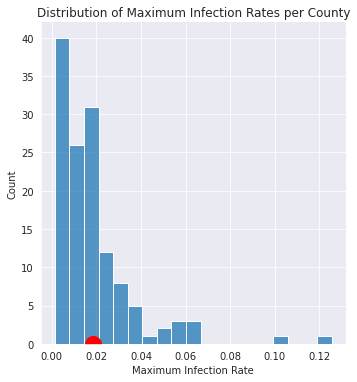

In [5]:
#Max proportion of infected individuals per county
max_prop = division_cases.max()
median_of_maxes =  np.mean(max_prop)
percentile_75 = max_prop.describe()[-2]
print(f'Median of maximal infection rates: {median_of_maxes}')

sns.displot(max_prop);
plt.title('Distribution of Maximum Infection Rates per County')
plt.xlabel('Maximum Infection Rate');
plt.plot(median_of_maxes, 0, marker='o', markersize=16, color="red");

In [6]:
#Classifying each county as high-risk or low-risk depending on if they are higher or lower than this (Constructing Y-response variable)
merged['high_risk'] = 0
merged.loc[(max_prop > median_of_maxes).values, 'high_risk'] = 1

#looking at how this classifies Calfornia's Counties
merged[merged['StateName'] == 'CA'][['CountyName', 'high_risk']]

,CountyName,high_risk
4,Los Angeles,0
50,Orange,1
58,Riverside,0
78,San Bernardino,0
90,San Diego,0
144,San Joaquin,0
148,Sacramento,0
156,Alameda,0
160,Fresno,0
164,Stanislaus,1


# Constructing Feature Matrix

In [7]:
#filtering out columns that contain case and death data
Y = merged['high_risk']
X = merged.iloc[:, pd.Series(merged.keys())[(~pd.Series(merged.keys()).str.contains(r'(#Case)|(#Death)', case = False))].index]

#filtering names of counties
X = X.iloc[:, 10:]
#two columns w/ a NaN, just dropped them instead of trying to impute
X = X.dropna(axis = 1)

X.columns = X.columns.str.replace('<', '')
display(X.info())
#one-hot encoding region names
X = X.join(pd.get_dummies(X['CensusRegionName'])).join(pd.get_dummies(X['CensusDivisionName'])).iloc[:, 2:]
X = X.select_dtypes(exclude=['object'])
X.drop(['high_risk', 'tot_cases', 'tot_deaths'], axis = 1, inplace= True)
print(X.shape)
X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 0 to 266
Columns: 161 entries, CensusRegionName to high_risk
dtypes: float64(96), int64(53), object(12)
memory usage: 173.3+ KB


/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


None

(133, 159)


,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale52010,PopFmle52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,...,LANGUAGE_Other_Than_ English,LANGUAGE_Limited_English,EMPLOYMENT_STATUS_Population_16_Years_And_Over,EMPLOYMENT_STATUS_In_Labor_Force,EMPLOYMENT_STATUS_Employed,EMPLOYMENT_STATUS_Unemployed,EMPLOYMENT_STATUS_Percent_Civilian_Labor_Force,EMPLOYMENT_STATUS_Not_in_Labor_Force,INCOME_12_MONTHS_Population,INCOME_12_MONTHS_With_Earnings,INCOME_12_MONTHS_Mean_Dollars_Earned,INCOME_12_MONTHS_WITH_Social_Security,INCOME_12_MONTHS_SS_Mean_Dollars,INCOME_12_MONTHS_With_Suppl_Security_Income,INCOME_12_MONTHS_Mean_Suppl_Sec_Dollars,INCOME_12_MONTHS_With_Cash_Public_Assistance,INCOME_12_MONTHS_With_Retirement_Income,INCOME_12_MONTHS_Mean_Retirement_Income_Dollars,INCOME_12_MONTHS_With_Food_Stamps,POVERTY_STATUS_Population,POVERTY_STATUS_Below_100_Percent_Level,POVERTY_STATUS_100_to_149_Percent_Level,POVERTY_STATUS_Above_150_Percent_Level,HOUSING_Total_Occupied_Units,HOUSING_HH_Size_Owner,HOUSING_HH_Size_Renter,HOUSING_No_Phone,Midwest,Northeast,South,West,East North Central,East South Central,Middle Atlantic,Mountain,New England,Pacific,South Atlantic,West North Central,West South Central
0,1,2582830,1254966,1393805,0.473792,356714,35369.2,2504700,34.1,386673,309657,635.0,9.7,195.8,19.5,13.840802,23.05,35442,9307,6,12,318,4.541512,90415,86783,81356,78035,79604,76959,86716,83968,96663,99134,106054,116788,97154,105704,161965,179580,149489,...,0.443,0.213,2050989.0,0.635,0.603,0.031,0.049,0.365,969317.0,0.783,102086.0,0.253,16939.0,0.090,9350.0,0.046,0.119,25240.0,0.223,2557510.0,0.190,0.096,0.714,969317.0,2.97,2.47,0.018,0,1,0,0,0,0,1,0,0,0,0,0,0
2,1,2278906,1143190,1215392,0.484694,354809,20553.6,2230722,37.2,374573,308099,411.0,10.2,180.0,22.2,12.427777,24.13,16874,7009,5,6,129,3.463349,67891,64573,63406,60360,62931,60475,71846,67250,81879,78996,91793,93124,88286,88927,162445,163834,156130,...,0.564,0.294,1869987.0,0.643,0.610,0.033,0.052,0.357,788110.0,0.809,93677.0,0.288,18027.0,0.056,9592.0,0.028,0.152,26479.0,0.130,2250553.0,0.115,0.090,0.795,788110.0,3.02,2.72,0.012,0,1,0,0,0,0,1,0,0,0,0,0,0
4,1,10105518,5009834,5153673,0.492924,1343960,2419.6,9818605,34.8,1530126,1276832,2515.0,8.1,150.8,33.9,10.847678,34.94,157325,36517,22,76,2126,3.201541,330265,315528,323676,310014,347102,331743,385012,368618,385393,367395,386393,373209,360263,355866,713640,716686,673001,...,0.569,0.230,8162030.0,0.650,0.613,0.036,0.056,0.350,3313908.0,0.828,99981.0,0.252,17850.0,0.069,9890.0,0.032,0.116,33920.0,0.083,9953165.0,0.141,0.100,0.759,3313908.0,3.20,2.83,0.013,0,0,0,1,0,0,0,0,0,1,0,0,0
6,1,5180493,2530605,2680658,0.485603,743329,5495.1,5194675,35.3,845162,686929,1166.0,9.0,175.1,38.7,13.776183,41.02,111488,26136,24,46,1606,3.556127,174153,168340,168600,163237,172848,166728,183431,176759,184841,187662,214382,221128,197362,198691,351648,358147,346934,...,0.356,0.135,4176128.0,0.663,0.619,0.044,0.066,0.337,1981796.0,0.795,99706.0,0.267,18451.0,0.055,9786.0,0.024,0.143,30800.0,0.139,5095522.0,0.137,0.083,0.780,1981796.0,2.74,2.33,0.015,1,0,0,0,1,0,0,0,0,0,0,0,0
8,1,1432132,693801,777359,0.471601,181313,32903.3,1385108,32.8,216750,159057,365.0,12.3,201.3,24.7,15.921169,31.58,34923,4813,6,6,270,9.356457,52481,50663,50271,48393,50693,48466,59451,56211,56609,56288,49741,55969,44868,52956,86313,10077

In [8]:
## creating train-test split
seed = 42
test_size = 0.2

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
X_train_labels = X_train.columns
scaler = StandardScaler()


scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
## fitting a quick logistic regression model
clf = LogisticRegressionCV(cv=5, random_state=0, max_iter = 10000).fit(X_train, Y_train)
fpr, tpr, thresholds = metrics.roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
auc = roc_auc_score(Y_test, clf.predict(X_test))
auc

0.5

# XGBoost Modeling

In [10]:
#defining function to calculate additional diagnostic scores
def calculate_scores(tn,fp, fn, tp):
    sens = tp / (tp+fn)
    spec = tn / (tn+fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    lr_pos = sens / (1-spec)
    lr_neg =  (1-sens)/ spec
    dor = (lr_pos)/(lr_neg)
    return sens, spec, ppv, npv, lr_pos, lr_neg, dor

#function meant to train a cross-validated xgb model and report results
def run_algo(X, Y, depth, lamb, pos_weight):
    # @param, X: training matrix
    # @param, Y: label vector
    # @param, depth: max_depth of each tree
    # @param, lamb: bias hyperparameter
    # @param, pos_weight: used to balance classes
    input_X = X
    X = np.matrix(X)[:,1:]
    Y = np.array([int(np.floor(i)) for i in Y])
    print('Starting 5-fold cross-validation...')
    senses, specs, ppvs, npvs, lr_poses, lr_negs, dors, aucs, auprcs = ([] for i in range(9)) 
    kf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model = XGBClassifier(max_depth=depth, reg_lambda=lamb, reg_alpha=0, scale_pos_weight=pos_weight, seed=3)
        model.fit(X_train, Y_train, eval_metric='logloss', early_stopping_rounds = 5, eval_set=[(X_test, Y_test)])
        preds = model.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(Y_test, preds).ravel()
        scores = calculate_scores(tn, fp, fn, tp)
        model_features = model.feature_importances_
        fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test)[:,1])
        auc = roc_auc_score(Y_test, model.predict(X_test))
        auprc = average_precision_score(Y_test, model.predict(X_test))
        senses.append(scores[0])
        specs.append(scores[1])
        ppvs.append(scores[2])
        npvs.append(scores[3])
        lr_poses.append(scores[4])
        lr_negs.append(scores[5])
        dors.append(scores[6])
        aucs.append(auc)
        auprcs.append(auprc)    
    print('Predictions done.')
    #reporting these scores for the last fold of cross-validation only
    print('Number of true positives: ', tp)
    print('Number of false positives: ', fp)
    print('Number of true negatives: ', tn)
    print('Number of false negatives: ', fn)
    #print('confusion matrix', [PPV,NPV,tn,fp,fn,tp])
    print('params', depth,lamb, pos_weight)
    #reporting average across all folds for these
    print('sens', np.mean(senses))
    print('spec', np.mean(specs))
    print('ppv', np.mean(ppvs))
    print('npv', np.mean(npvs))
    print('auroc', np.mean(aucs))
    print('auroc std dev', np.std(aucs))
    print('LR+', np.mean(lr_poses))
    print('LR-', np.mean(lr_negs))
    print('DOR', np.mean(dors))
    print('auprc', np.mean(auprcs))
    print('total number of positive encounters', sum(Y_train)+sum(Y_test))
    print('total number of negative encounters', len(Y_train) + len(Y_test))
    #refitting with original matrix to preserve feature labels
    X_train, X_test, Y_train, Y_test = train_test_split(input_X, Y, test_size=test_size, random_state=seed)
    model = XGBClassifier(max_depth=depth, reg_lambda=lamb, reg_alpha=0, scale_pos_weight=pos_weight, seed=3)
    model.fit(X_train, Y_train, eval_metric='logloss',
              early_stopping_rounds = 5, eval_set=[(X_test, Y_test)], verbose = False)
    model_features = model.feature_importances_
    #print('Feature Importances', model_features)
    ax = plot_importance(model, importance_type = 'gain', max_num_features = 20)
    #ax.figure.savefig('models/best_model/fp_fig_' + model_name)
    display(ax)
    return fpr, tpr, np.mean(aucs), model, [np.mean(ppvs),np.mean(npvs),tn,fp,fn,tp]

Starting 5-fold cross-validation...
[0]	validation_0-logloss:0.692975
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.691957
[2]	validation_0-logloss:0.690999
[3]	validation_0-logloss:0.690099
[4]	validation_0-logloss:0.691067
[5]	validation_0-logloss:0.690227
[6]	validation_0-logloss:0.691224
[7]	validation_0-logloss:0.692247
[8]	validation_0-logloss:0.691471
Stopping. Best iteration:
[3]	validation_0-logloss:0.690099

[0]	validation_0-logloss:0.692759
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.692456
[2]	validation_0-logloss:0.692552
[3]	validation_0-logloss:0.69273
[4]	validation_0-logloss:0.693015
[5]	validation_0-logloss:0.692846
[6]	validation_0-logloss:0.692939
Stopping. Best iteration:
[1]	validation_0-logloss:0.692456

[0]	validation_0-logloss:0.692056
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.691367
[2]	validation_0-logloss:0.690

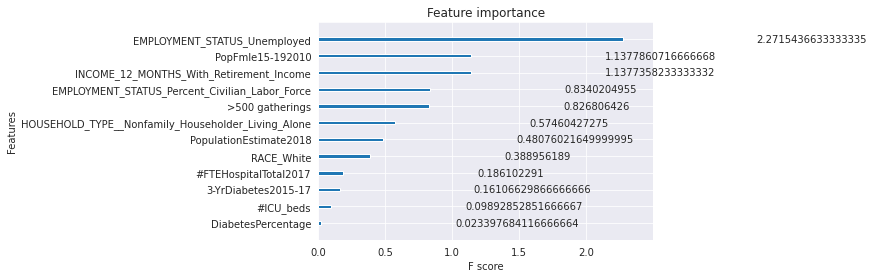

In [11]:
fpr, tpr, auc, model, confusion = run_algo(X, Y, 4, 100, 2)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


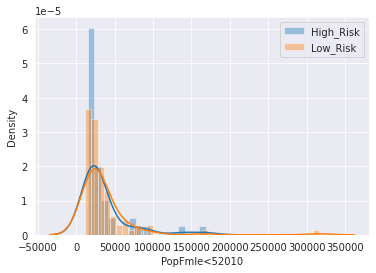

In [12]:
#the gain represented in the above feature importance plot is likely due to 
#random chance (small sample size)
sns.distplot(merged[merged['high_risk'] == 1]['PopFmle<52010'], label = 'High_Risk')
sns.distplot(merged[merged['high_risk'] == 0]['PopFmle<52010'], label = "Low_Risk")
plt.legend();

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


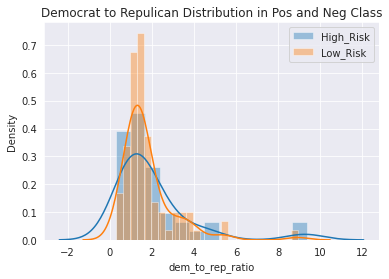

In [13]:
#the gain represented in the above feature importance plot is likely due to 
#random chance (small sample size)
sns.distplot(merged[merged['high_risk'] == 1]['dem_to_rep_ratio'], label = 'High_Risk')
sns.distplot(merged[merged['high_risk'] == 0]['dem_to_rep_ratio'], label = "Low_Risk")
plt.title('Democrat to Repulican Distribution in Pos and Neg Class')
plt.legend();

In [14]:
## creating train-test split
seed = 41
test_size = 0.2

#redefining Y for regression (normalized case count per county)
Y_new = merged['tot_cases']/merged['PopulationEstimate2018']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_new, test_size=test_size, random_state=seed)
scaler = StandardScaler()


scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
#fitting a regression instead
xgb_r = xgb.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123) 
  
# Fitting the model
xgb_r.fit(X_train, Y_train.values*100) 
display((Y_train*100).describe()) 
# Predict the model 
pred = xgb_r.predict(X_test) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(Y_test.values*100, pred)) 
print("RMSE : % f" %(rmse))

[14:59:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


count    106.000000
mean       2.376045
std        0.896173
min        0.876869
25%        1.767651
50%        2.204737
75%        2.952305
max        6.402456
dtype: float64

RMSE :  1.015915


# PCA Dimensionality Reduction

In [16]:
from sklearn.decomposition import PCA

#fitting a PCA to capture 95% of the variance
pca = PCA(0.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [18]:
pd.DataFrame(X_train_pca)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,4.728655,5.612651,-6.503470,1.830416,0.640192,0.301151,-1.893139,-0.089796,1.530942,-1.929888,0.444045,0.244823,2.733897,-0.097268,-0.620353,2.581331,-0.806086,1.520921,1.896556,-0.336378,0.342964,-0.451975,-0.120821
1,-0.040304,7.745175,14.348465,-1.934987,-1.944202,-5.266661,2.717066,-4.228954,1.316813,-1.334313,1.301014,2.103211,1.092208,0.313216,-0.218684,-0.922261,-0.367934,0.430227,0.907707,-0.422892,1.654879,1.666401,0.624041
2,-3.342386,-6.669062,3.152490,0.278849,1.429719,-4.358001,0.475014,1.250479,-0.717003,-0.231789,1.860217,-0.038157,2.070872,-0.281178,-1.708486,0.330107,1.247286,0.192535,-0.211867,-1.031342,-1.651054,0.907279,0.401097
3,-4.903985,4.496104,-0.203059,1.359971,-2.814732,-0.373642,-1.776277,0.344474,-1.349862,-0.048559,-0.932611,-0.733158,0.205717,0.077678,-0.778356,0.308586,-0.351803,0.272512,-0.354467,-0.368710,0.203801,-1.606065,0.105757
4,15.433747,-0.917209,3.449539,0.680003,5.293773,-4.517827,1.782752,-1.001591,-1.862918,0.101931,-0.792396,1.160958,0.790974,0.084135,-1.263539,-0.077561,1.130616,-0.193555,-0.879492,-1.104465,-0.572221,-0.772780,-0.626493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,-3.167220,-1.266412,-0.100321,-3.873393,2.568985,5.219919,-2.708697,2.291978,-1.637073,-0.030661,0.741392,-1.989649,1.467980,-1.422966,-1.309211,-0.394602,1.634459,0.817662,0.715427,0.832180,0.777385,1.039014,-1.260647
102,9.061231,2.909588,3.622646,-1.989723,3.085699,-2.230008,1.398358,-0.717403,-2.079007,-1.933634,2.472124,0.287442,0.910657,0.117556,-1.790235,0.531648,0.125740,-1.166839,-0.546519,-0.552080,0.793835,-0.284378,0.115619
103,-5.242234,4.857903,-5.570524,-6.221772,-2.430606,1.289662,3.485954,0.803503,0.473135,0.936583,-0.435303,0.570417,1.401070,-0.146574,-0.498240,0.979535,-0.567759,-0.659097,-1.093805,0.959471,0.228658,0.282165,0.278992
104,0.302227,5.383105,-1.167026,2.820492,2.857501,0.248077,-1.553102,-0.839606,1.836418,-1.314959,-3.080992,0.549050,0.886092,0.492041,0.557970,0.444515,0.802214,0.498489,0.065972,-0.314324,-0.774354,-0.213753,-0.028102


# Random Forest Regression

In [19]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth = 5)
# Train the model on training data
rf.fit(X_train, Y_train*100);

Root Mean Squared Error: 0.63 percent of the population.


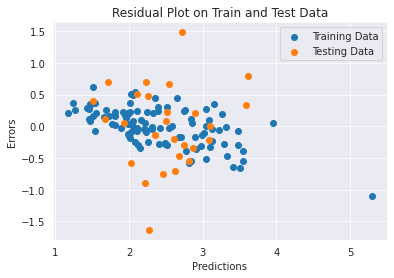

In [20]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the errors
errors = (predictions - Y_test*100)

print('Root Mean Squared Error:', round(np.sqrt(np.mean(errors**2)), 2),  'percent of the population.')

#plotting the residuals to visually validate results
x_preds = rf.predict(X_train)
x_errors = (x_preds - Y_train*100)
plt.scatter(x_preds, x_errors, label = 'Training Data')
plt.scatter(predictions,errors, label = 'Testing Data')
plt.xlabel('Predictions')
plt.ylabel('Errors')
plt.title('Residual Plot on Train and Test Data')
plt.legend();

In [21]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_train, Y_train, n_repeats=10,
                                random_state=42, n_jobs=2)

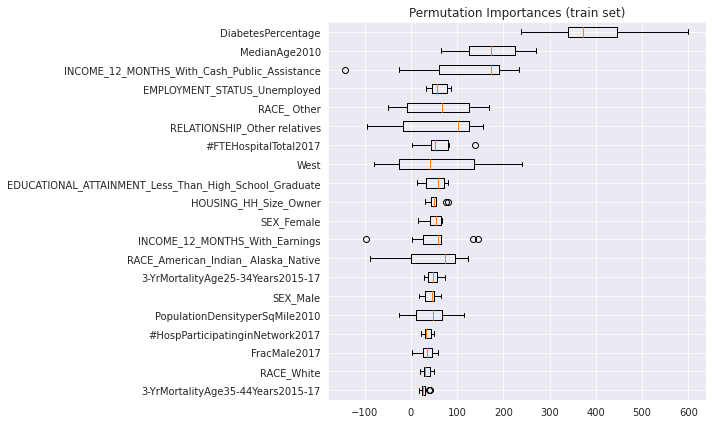

In [34]:
#generating a permutation feature importance plot (accounts for bias in MDI)
sorted_idx= result.importances_mean.argsort()
fig, ax = plt.subplots(figsize = (10, 6))
ax.boxplot(result.importances[sorted_idx][-20:].T,vert=False,
           labels = X_train_labels[sorted_idx][-20:])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()